# Customer Churn Prediction and Analysis

## Overview
To predict customer churn using a dataset of customer features and behavior.
- Train a predictive model using Gradient Boosted Trees (XGBoost) to classify customers as "churn" or "not churn".
- Evaluate the model's performance using key metrics like AUC (Area Under the Curve) and confusion matrix.
- Optimize the classification threshold to minimize costs associated with false positives and false negatives.




In [2]:
import io
import os
import sys
import json
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sagemaker import get_execution_role, Session
from IPython.display import display
from sagemaker.inputs import TrainingInput
# from sagemaker.serializers import CSVSerializer

# Initialize SageMaker session and IAM role
sess = Session()
role = get_execution_role()

# S3 bucket and file information
bucket = "sagemaker-studio-183631337126-gnq7iddyj68"
file_key = "cleaned_churn.csv"
local_file = "cleaned_churn.csv"

In [3]:
# Download the file from S3 to local environment
s3 = boto3.client("s3")
s3.download_file(bucket, file_key, local_file)

In [4]:
# Load the CSV data into Pandas
churn = pd.read_csv(local_file)
pd.set_option("display.max_columns", 500)

In [5]:
# Display the first few rows
churn.head()

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [37]:
# Check if there are any NA values in the dataset
print(churn.isna().any().any())


False


## Dataset Description
The dataset contains several features related to customer behavior, such as:
- **State**: US state in which the customer resides
- **Account_Length**: Length of the customer's account.
- **Area_code**: Three-digit area code of the custoemr's phone number
- **Phone**: Remaining seven-digit phone number.
- **Intl_Plan**: Whether the customer has an international calling plan
- **VMail_Plan**: Whether the customer has a voice mail feature
- **VMail_Message**: Number of voicemail messages the customer has received.
- **Day_Mins**: Total minutes of the customer's calls during the day.
- **Day_Calls**: Number of calls made by the customer during the day.
- **Day_Charge**: The cost of the customer's day calls.
- **Eve_Mins**: Total minutes of the customer's calls during the evening.
- **Eve_Calls**: Number of calls made by the customer during the evening.
- **Eve_Charge**: The cost of the customer's evening calls.
- **Night_Mins**: Total minutes of the customer's calls during the night.
- **Night_Calls**: Number of calls made by the customer during the night.
- **Night_Charge**: The cost of the customer's night calls.
- **Intl_Mins**: Total minutes of the customer's international calls.
- **Intl_Calls**: Number of international calls made by the customer.
- **Intl_Charge**: The cost of the customer's international calls.
- **CustServ_Calls**: Number of calls made to customer service by the customer.
- **Churn**: Whether the customer left the service

In [6]:
len(churn.columns)

21

In [7]:
np.shape(churn)

(3333, 21)

In [8]:
# Frequency tables for categorical features
for column in churn.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
...,...
422-7728,0.0003
422-8268,0.0003
422-8333,0.0003


col_0,% observations
Intl_Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail_Plan,
no,0.723372
yes,0.276628


In [9]:
display(churn.describe())

,Account_Length,Area_Code,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


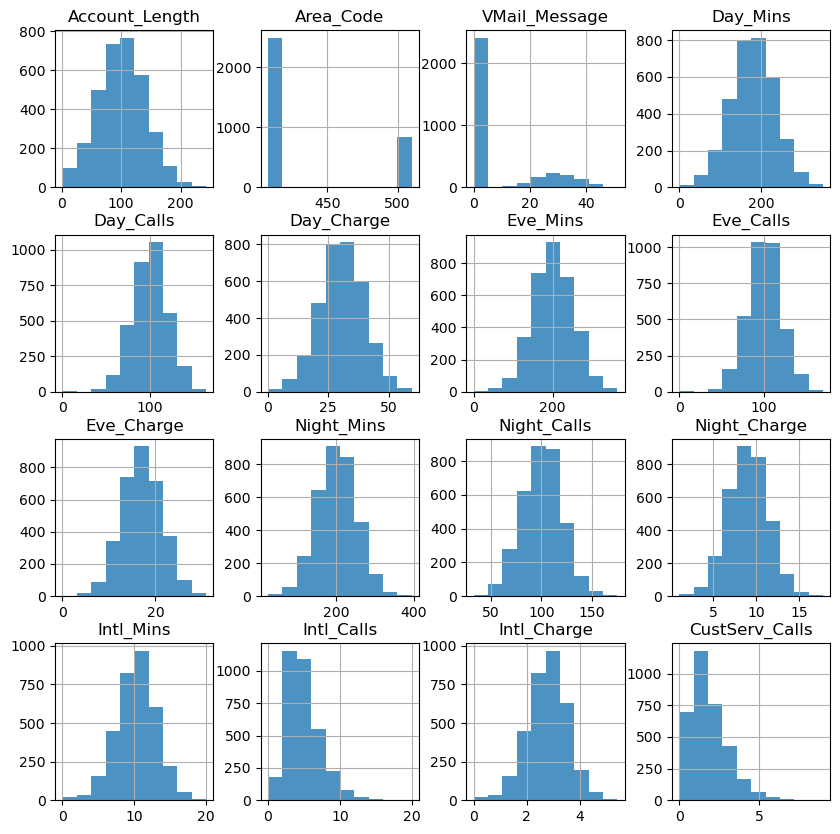

In [10]:
# Histograms for numeric features
%matplotlib inline
hist = churn.hist(alpha=0.8, figsize=(10, 10))

In [11]:
# Optional: Drop irrelevant features
churn = churn.drop("Phone", axis=1)  # Remove the 'Phone' column as it's not predictive

In [12]:
np.shape(churn)

(3333, 20)

In [13]:
churn.dtypes

State              object
Account_Length      int64
Area_Code           int64
Intl_Plan          object
VMail_Plan         object
VMail_Message       int64
Day_Mins          float64
Day_Calls           int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
Intl_Calls          int64
Intl_Charge       float64
CustServ_Calls      int64
Churn                bool
dtype: object

In [14]:
# Convert 'Area Code', 'Churn' to a categorical feature
churn["Area_Code"] = churn["Area_Code"].astype("object")
churn["Churn"] = churn["Churn"].astype("object")

In [15]:
# Cross-tabulate categorical features with the target variable
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn":
        display(pd.crosstab(index=churn[column], columns=churn["Churn"], normalize="columns"))


Churn,False,True
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn,False,True
Area_Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn,False,True
Intl_Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn,False,True
VMail_Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


### Data Correlation
Understanding correlations between numerical variables is crucial for identifying potential relationships and redundancy in features. High correlations (i.e., >0.8 or < -0.8) indicate that two or more features are strongly related and can be used interchangeably in certain models, or one of them might be dropped to reduce multicollinearity.


,Account_Length,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
Account_Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail_Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day_Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day_Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day_Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve_Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve_Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve_Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night_Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night_Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


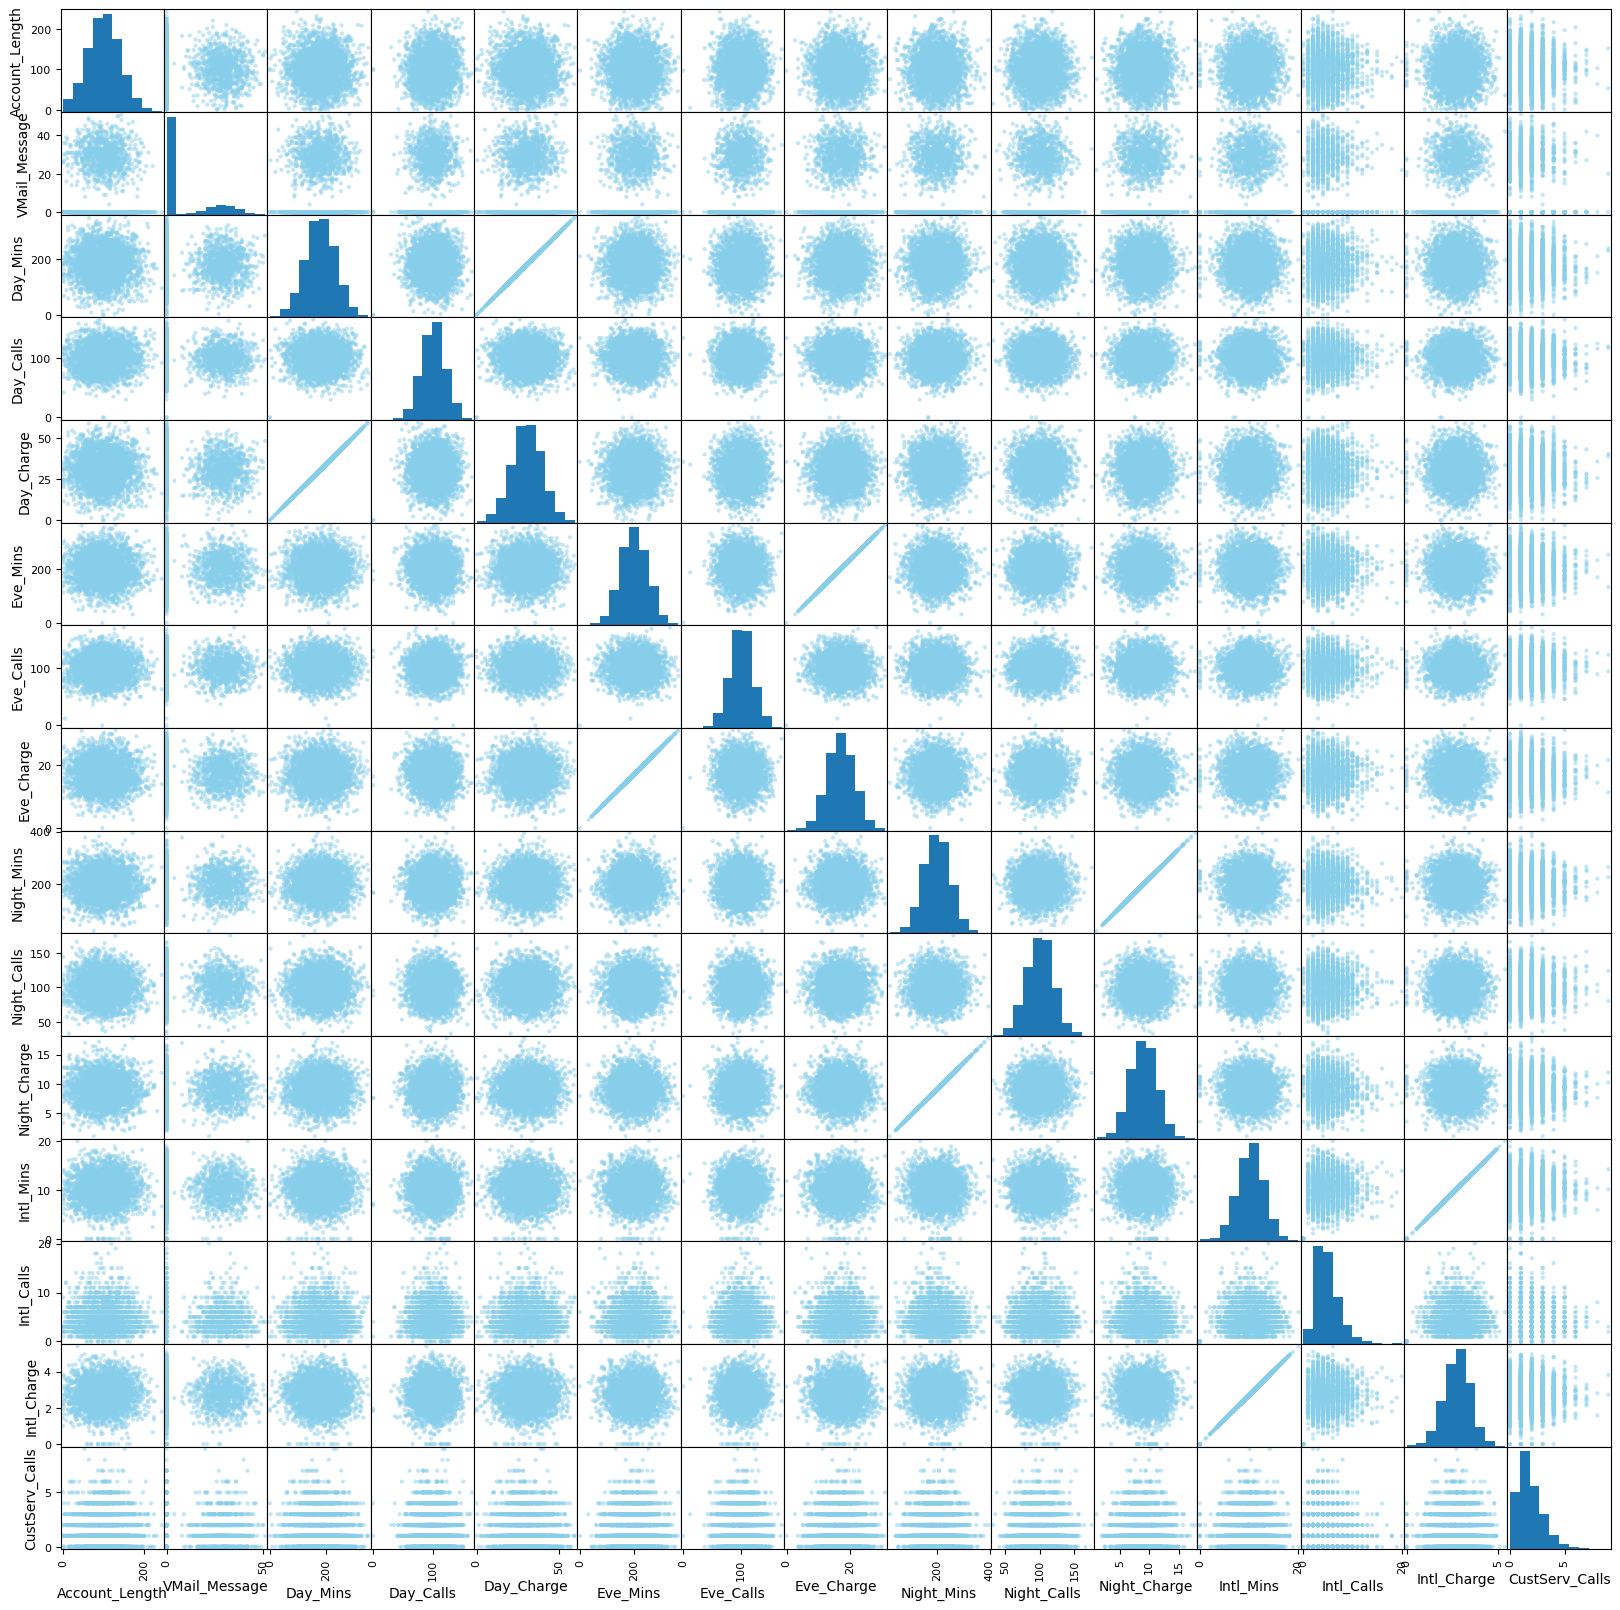

In [16]:
# Drop non-numeric columns for correlation
numeric_churn = churn.select_dtypes(include=["number"])
corr_matrix = numeric_churn.corr()
# Display the correlation matrix
display(corr_matrix)

# Scatter matrix for numeric columns
pd.plotting.scatter_matrix(numeric_churn, figsize=(20, 20), alpha=0.5, diagonal="hist", color="skyblue")

# Show the plot
plt.show()


## Key Findings from the Correlation Matrix:
### High Correlations: 
Features such as ```Day_Mins``` and ```Day_Charge```, ```Night_Mins``` and ```Night_Charge```, ```Eve_Mins``` and ```Eve_Charge```, ```Intl_Mins``` and ```Intl_Charge``` show a perfect correlation of 1.0. This indicates that these features change together in a predictable manner (e.g., cost is directly proportional to the minutes spent on calls).

### Redundant Features: 
Columns like ```Night_Mins``` and ```Night_Charge```, or ```Intl_Mins``` and ```Intl_Charge```, represent redundant information, and one of them could be dropped to reduce dimensionality and prevent multicollinearity in the model.

### Identifying and Removing Highly Correlated Features:
For any features with a correlation coefficient greater than 0.8 (or less than -0.8), one feature from each highly correlated pair should be dropped to improve the quality of the model. 

In [17]:
# Find pairs of columns with correlation > 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly correlated column pairs:")
for pair in high_corr_pairs:
    print(pair)


Highly correlated column pairs:
('Day_Charge', 'Day_Mins')
('Eve_Charge', 'Eve_Mins')
('Night_Charge', 'Night_Mins')
('Intl_Charge', 'Intl_Mins')


In [18]:
# Drop features from the highly correlated pairs
features_to_drop = [pair[1] for pair in high_corr_pairs]  # Drop the second feature of each pair

# Drop the features
churn_cleaned = churn.drop(columns=features_to_drop)

# Verify the cleaned data
print(f"Remaining columns after dropping highly correlated features: {churn_cleaned.columns.tolist()}")


Remaining columns after dropping highly correlated features: ['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Churn']


In [19]:
np.shape(churn_cleaned)

(3333, 16)

In [20]:
# converting our categorical features into numeric features.
model_data = pd.get_dummies(churn_cleaned)
model_data = pd.concat([model_data["Churn_True"], model_data.drop(["Churn_False", "Churn_True"], axis=1)], axis=1)
model_data

,Churn_True,Account_Length,VMail_Message,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,CustServ_Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area_Code_408,Area_Code_415,Area_Code_510,Intl_Plan_no,Intl_Plan_yes,VMail_Plan_no,VMail_Plan_yes
0,False,128,25,110,45.07,99,16.78,91,11.01,3,2.70,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True
1,False,107,26,123,27.47,103,16.62,103,11.45,3,3.70,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True
2,False,137,0,114,41.38,110,10.30,104,7.32,5,3.29,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False
3,False,84,0,71,50.90,88,5.26,89,8.86,7,1.78,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False
4,False,75,0,113,28.34,122,12.61,121,8.41,3,2.73,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,False,192,36,77,26.55,126,18.32,83,12.56,6,2.67,2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True
3329,False,68,0,57,39.29,55,13.04,123,8.61,4,2.59,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False
3330,False,28,0,109,30.74,58,24.55,91,8.64,6,3.81,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [21]:
print(model_data.columns)

Index(['Churn_True', 'Account_Length', 'VMail_Message', 'Day_Calls',
       'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge',
       'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'State_WY', 'Area_Code_408', 'Area_Code_415', 'Area_Code_510',
       'Intl_Plan_no', 'Intl_Plan_yes', 'VMail_Plan_no', 'VMail_Plan_yes

In [22]:
from sklearn.model_selection import train_test_split

# Features
X = model_data.drop("Churn_True", axis=1)  # All features except the target
# Target variable
y = model_data["Churn_True"]

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


XGBoost: Ml algorithm that uses gradient boosting to make predictions, gradient boosting excels at capturing non-linear relationships between features and the target variables and can handle complex interactions between features. Customer behaviour can be influenced by various factors in a non-linear way. 
```max_depth``` controls the maximum depth of each tree in the model. 
```num_rounds``` specifies the number of boosting rounds, each boosting round adds a new tree to the model, attempting to correct the errors made by the previous trees. 

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert data into DMatrix format (specific to XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Binary classification (churn or not)
    'eval_metric': 'logloss',  # Log loss as the evaluation metric
    'max_depth': 6,  # Depth of trees
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Fraction of samples to use for each tree
    'colsample_bytree': 0.8  # Fraction of features to use for each tree
}
# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(dtest)

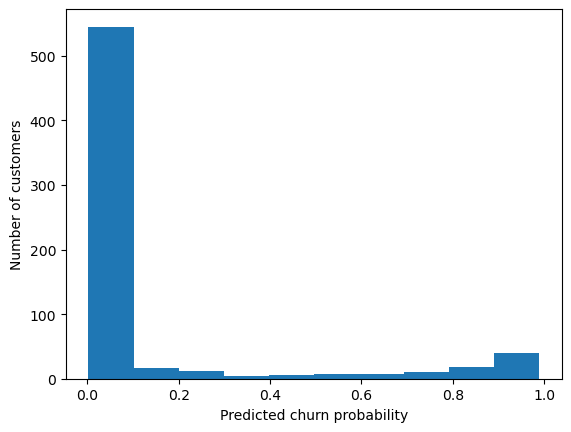

In [24]:
plt.hist(y_pred)
plt.xlabel("Predicted churn probability")
plt.ylabel("Number of customers")
plt.show()

In [25]:
y_pred_1 = (y_pred > 0.5).astype(int)  # Convert probabilities to binary outcomes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_1)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9595


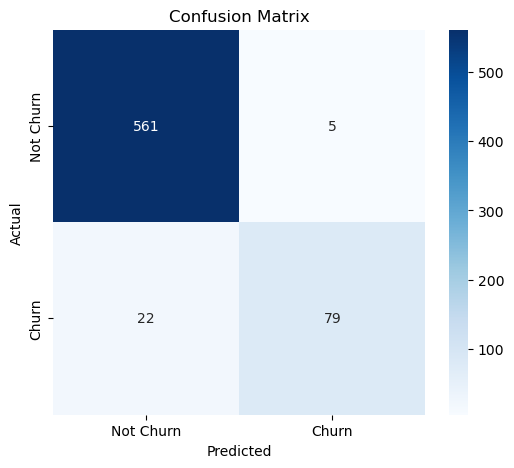

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1)
# The confusion matrix provides insights into the performance of the model by showing the counts of true positives, true negatives, false positives, and false negatives.

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Lowering the threshold increases the chance of catching potential churners (true positives), but also increases the likelihood of unnecessarily targeting loyal customers (false positives)

An ROC curve visually represents this trade-off across all possible thresholds. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values.
- A high true positive rate means the model correctly identifies a large proportion of actual churners.
-  A low false positive rate means the model minimizes incorrectly flagging loyal customers as churn risks.

AUC: 0.9185


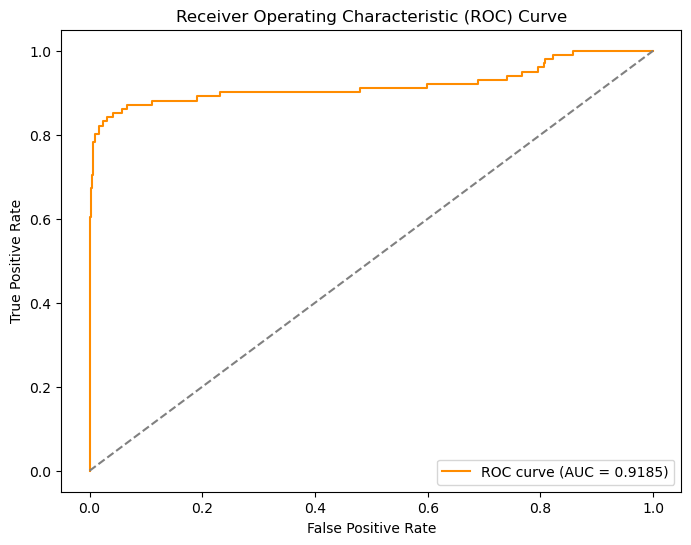

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities (not labels) from the model
y_pred_prob = model.predict(dtest)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='lower right')
plt.show()


In [29]:
# 3. Define the cost matrix (from the sources)
cost_matrix = np.array([[0, 100], [500, 100]])

# 4. Calculate the cost for each threshold
costs = []
for threshold in thresholds:
    # Obtain predicted labels based on the current threshold
    predicted_labels = (y_pred_prob > threshold).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    
    # Calculate the cost 
    cost = np.sum(cm * cost_matrix)
    costs.append(cost)

# 5. Find the optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Minimum Cost: {min_cost}")

Optimal Threshold: 0.2708
Minimum Cost: 18500


Accuracy: 0.9550


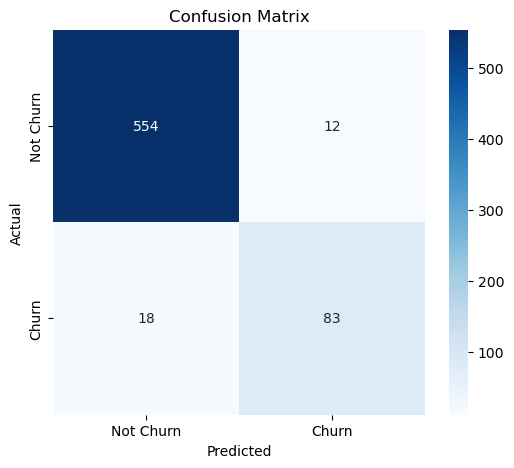

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_1 = (y_pred > optimal_threshold).astype(int)  # Convert probabilities to binary outcomes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_1)
print(f"Accuracy: {accuracy:.4f}")
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred_1)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


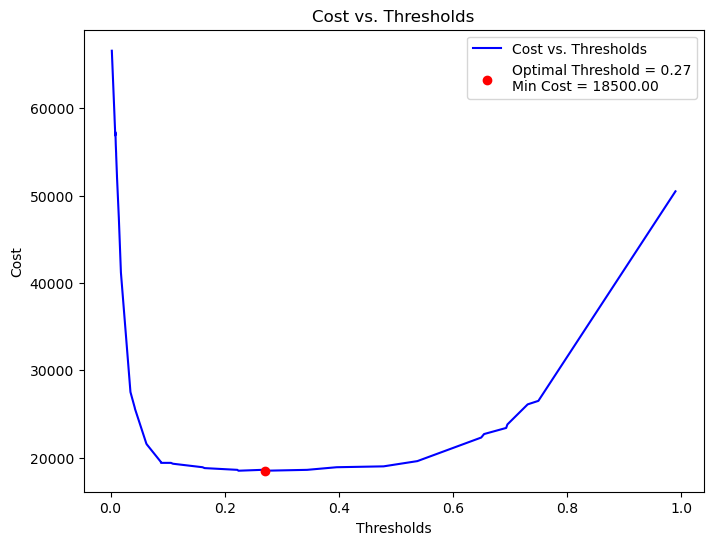

In [35]:
# Plot the thresholds vs. costs
plt.figure(figsize=(8, 6))
plt.plot(thresholds, costs, label="Cost vs. Thresholds", color="blue")
plt.scatter(optimal_threshold, min_cost, color="red", label=f"Optimal Threshold = {optimal_threshold:.2f}\nMin Cost = {min_cost:.2f}", zorder=5)

# Add labels and title
plt.xlabel("Thresholds")
plt.ylabel("Cost")
plt.title("Cost vs. Thresholds")
plt.legend(loc="upper right")
plt.show()


## Cost Analysis

In [59]:
churn_cost = 500  # Cost of a churned customer
retention_cost = 100  # Cost to retain a customer
prior_churn_rate = (np.sum(churn['Churn'] == True) / len(churn['Churn']))  # Historical churn rate for training data
val_prior_churn_rate = (np.sum(y_test == True) / len(y_test)) # churn rate for validation data

# Metrics from the ML model
false_negative_rate = cm[1][0]/np.sum(cm)
true_positive_rate = cm[1][1]/np.sum(cm)
false_positive_rate = cm[0][1]/np.sum(cm)

# Costs without ML
cost_without_ml = val_prior_churn_rate * churn_cost

# Costs with ML
# False negatives incur churn cost
false_negative_cost = false_negative_rate * churn_cost

# Retention cost for true positives and false positives
retention_total = (true_positive_rate + false_positive_rate) * retention_cost

# Total cost with ML
cost_with_ml = false_negative_cost + retention_total

# Print results
print(f"Cost without ML: ${cost_without_ml:.2f}")
print(f"Cost with ML: ${cost_with_ml:.2f}")
print(f"Cost reduction: ${(cost_without_ml - cost_with_ml):.2f}")
print(f"Percentage reduction: {((cost_without_ml - cost_with_ml) / cost_without_ml) * 100:.2f}%")


Cost without ML: $75.71
Cost with ML: $27.74
Cost reduction: $47.98
Percentage reduction: 63.37%


In [61]:
population_size = 100_000  # Total number of customers

# Calculate total costs and savings
total_cost_without_ml = cost_without_ml * population_size
total_cost_with_ml = cost_with_ml * population_size
total_savings = total_cost_without_ml - total_cost_with_ml
percentage_reduction = (total_savings / total_cost_without_ml) * 100

# Print results
print(f"Cost without ML (for {population_size} customers): ${total_cost_without_ml:,.2f}")
print(f"Cost with ML (for {population_size} customers): ${total_cost_with_ml:,.2f}")
print(f"Total savings: ${total_savings:,.2f}")
print(f"Percentage reduction: {percentage_reduction:.2f}%")


Cost without ML (for 100000 customers): $7,571,214.39
Cost with ML (for 100000 customers): $2,773,613.19
Total savings: $4,797,601.20
Percentage reduction: 63.37%


## Conclusion: 

By leveraging the XGBoost model for churn prediction, we can significantly reduce the costs associated with customer churn. Here are the financial outcomes and potential savings:

### Scaling a population of 100,000 customers, the total savings achieved by using the XGBoost model would be over $4MM in savings by using ML 